# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html).

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

np.random.seed(69)
torch.manual_seed(99)

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [2]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# load the data set
with open('/content/drive/MyDrive/train_data.pkl', 'rb') as fuk:
    dataset = pickle.load(fuk)

X = dataset['X']
y = dataset['y']

# normalize
MMS = MinMaxScaler()
X_trans = MMS.fit_transform(X)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

X_tr, X_te, y_tr, y_te = train_test_split(X_trans, y, test_size=0.2, random_state=666)


Mounted at /content/drive


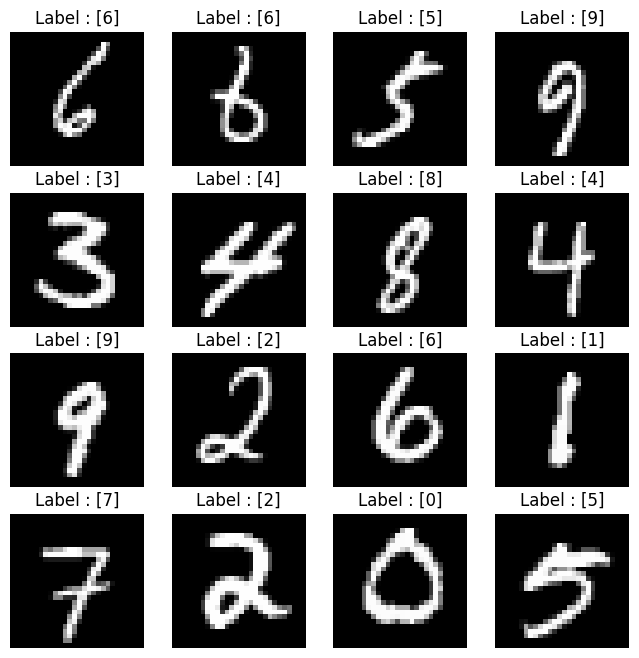

In [3]:
# display a 4x4 grid,
grid = (4,4)
# choose 16 images randomly, display the images as well as corresponding labels
indices = np.random.choice(X_tr.shape[0], size=grid[0]*grid[1], replace=False)
images = X_tr[indices]
labels = y_tr[indices]

fig, axes = plt.subplots(grid[0], grid[1], figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(28, 28), cmap='gray')
    ax.set_axis_off()
    ax.set_title(f"Label : {labels[i]}")

fig.tight_layout

plt.show()

#print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [4]:
# define your dataset class

class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.x_data = torch.tensor(X, dtype=torch.float32)
        self.y_data = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)

# Create instances of the dataset class for train and test sets
train_data = MNISTDataset(X_tr, y_tr)
test_data = MNISTDataset(X_te, y_te)


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [5]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class NeuralNet(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out



## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [6]:
def train(model, optimizer, criterion, train_loader, num_epochs, display_step=None):
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28)
            labels = labels.reshape(-1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [7]:
def init_weights(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            nn.init.zeros_(layer.bias)


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [8]:
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        predictions = torch.argmax(logits, dim=1).numpy()
    return predictions

In [9]:
def accuracy(pred, labels):
    return (np.sum(pred == labels))/pred.shape[0]

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [10]:
model = NeuralNet(256)
# Initialize the weights of the model
init_weights(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for train and test sets
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

# Train the model
num_epochs = 10
train(model, optimizer, criterion, train_loader, num_epochs, display_step=100)



Epoch [1/10], Step [100/750], Loss: 0.4008
Epoch [1/10], Step [200/750], Loss: 0.4013
Epoch [1/10], Step [300/750], Loss: 0.2994
Epoch [1/10], Step [400/750], Loss: 0.2327
Epoch [1/10], Step [500/750], Loss: 0.1065
Epoch [1/10], Step [600/750], Loss: 0.1605
Epoch [1/10], Step [700/750], Loss: 0.1137
Epoch [2/10], Step [100/750], Loss: 0.1355
Epoch [2/10], Step [200/750], Loss: 0.0352
Epoch [2/10], Step [300/750], Loss: 0.0984
Epoch [2/10], Step [400/750], Loss: 0.0829
Epoch [2/10], Step [500/750], Loss: 0.1861
Epoch [2/10], Step [600/750], Loss: 0.0723
Epoch [2/10], Step [700/750], Loss: 0.0275
Epoch [3/10], Step [100/750], Loss: 0.0489
Epoch [3/10], Step [200/750], Loss: 0.0413
Epoch [3/10], Step [300/750], Loss: 0.0402
Epoch [3/10], Step [400/750], Loss: 0.0831
Epoch [3/10], Step [500/750], Loss: 0.1381
Epoch [3/10], Step [600/750], Loss: 0.1725
Epoch [3/10], Step [700/750], Loss: 0.0337
Epoch [4/10], Step [100/750], Loss: 0.0116
Epoch [4/10], Step [200/750], Loss: 0.0240
Epoch [4/10

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [15]:
# Get predictions for the test set
y_pred = predict(model, X_te)

# Calculate accuracy on the test set
test_accuracy = accuracy(y_pred, y_te.reshape(-1))
print(f"Test Accuracy: {(100 * test_accuracy):.4f} %")


Test Accuracy: 97.6917


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [12]:
from google.colab import files
torch.save(model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [14]:
# load the model, use predict function
model1=torch.load('/content/ass_2.pt')
y_pred = predict(model1, X_te)
test_accuracy = accuracy(y_pred, y_te.reshape(-1))
print(f"Test Accuracy: {(100 * test_accuracy):.4f}")

Test Accuracy: 97.6917
